In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
POWERS = ['0', '4', '3', '2', '1']
# POWERS = ['0', '2']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n20/"

def get_chance(power):
    if power == '0':
        return '100'
    elif power == '4':
        return '93.75'
    elif power == '3':
        return '87.5'
    elif power == '2':
        return '75'
    elif power == '1':
        return '50'
    
def get_power_index(power):
    if power == '0':
        return 0
    elif power == '4':
        return 1
    elif power == '3':
        return 2
    elif power == '2':
        return 3
    elif power == '1':
        return 4
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in POWERS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in POWERS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in POWERS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in POWERS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in POWERS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in POWERS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in POWERS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in POWERS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in POWERS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in POWERS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in POWERS]
PLOT_X = [get_chance(p) + '%' for p in POWERS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_power, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_power, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in POWERS:
        runSketchTweets("SketchingTweet-v2-n20", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(POWERS)
    termfreq = [0] * len(POWERS)
    query_result = [0] * len(POWERS)
    query_similarity = [0] * len(POWERS)
    query_lookups = [0] * len(POWERS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(POWERS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(POWERS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            power = filename.group(4)

            if name == "summary":    
                for p in POWERS:
                    if power == p:
                        summary[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in POWERS:
                    if power == p:
                        termfreq[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in POWERS:
                    if power == p:
                        query_result[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in POWERS:
                    if power == p:
                        query_similarity[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in POWERS:
                    if power == p:
                        query_lookups[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in POWERS:
                    if power == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_power_index(power)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in POWERS:
                    if power == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_power_index(power)][i] = pd.read_csv(directory + "/" + file, header=None)
                  

    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [6]:
results = run_expm1() 

# Process Results

In [7]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [8]:
summary = results['summary']
summary

,Summary_100%,Summary_93.75%,Summary_87.5%,Summary_75%,Summary_50%
Run,1,1,1,1,1
Chance,100.0%,93.75%,87.5%,75.0%,50.0%
Index time unit,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,22852,22852,22852,22852,22852
Indexed tweet counts,206118,206118,206118,206118,206118
Index size,226214,212562,198611,170765,114666


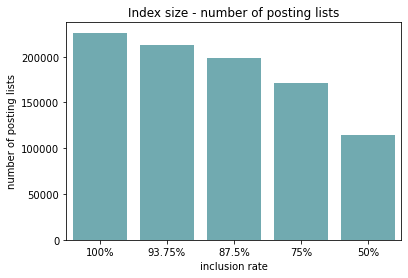

Summary_100%      226214
Summary_93.75%    212562
Summary_87.5%     198611
Summary_75%       170765
Summary_50%       114666
Name: Index size, dtype: object

In [9]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

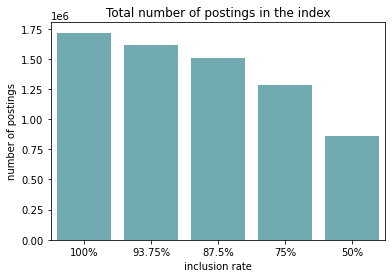

Total number of postings:


[1716734, 1617372, 1507519, 1286718, 860177]

In [10]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

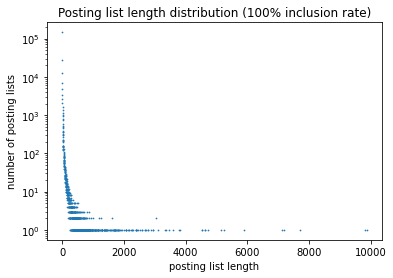

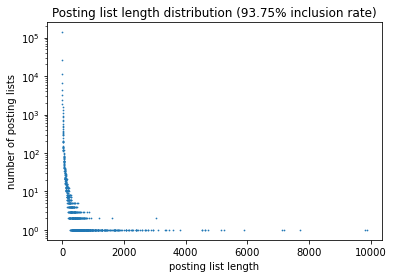

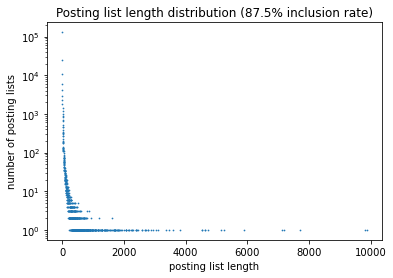

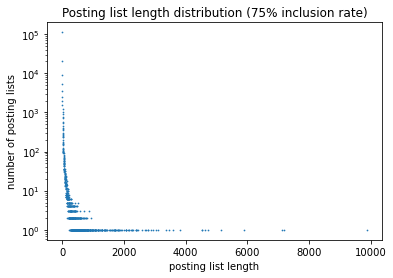

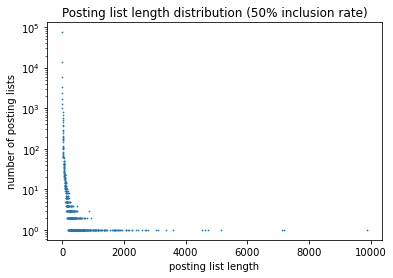

In [11]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.588982114281167, 7.60894233211957, 7.5903097008725595, 7.53502181360349, 7.50158721853034]


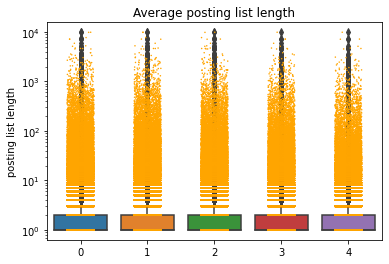

In [12]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_93.75%,Result_87.5%,Result_75%,Result_50%,Similarity_100%,Similarity_93.75%,Similarity_87.5%,Similarity_75%,Similarity_50%,Lookups_100%,Lookups_93.75%,Lookups_87.5%,Lookups_75%,Lookups_50%
0,197710,197710,197710,197710,197710,0.57143,0.58333,0.58333,0.60000,0.50000,7350,3612,3612,2960,666
1,152573,152573,152573,103379,103379,0.50000,0.50000,0.50000,0.66667,0.66667,6966,6966,6966,2511,2511
2,-1,-1,-1,-1,152451,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,464
3,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,205139,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22847,-1,-1,-1,196136,205121,0.00000,0.00000,0.00000,0.50000,1.00000,-1,-1,-1,164,1
22848,-1,-1,-1,-1,100625,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,1552
22849,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1
22850,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1


In [14]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_93.75%,Result_87.5%,Result_75%,Result_50%,Similarity_100%,Similarity_93.75%,Similarity_87.5%,Similarity_75%,Similarity_50%,Lookups_100%,Lookups_93.75%,Lookups_87.5%,Lookups_75%,Lookups_50%
0,197710,197710,197710,197710,197710,0.57143,0.58333,0.58333,0.60000,0.50000,7350,3612,3612,2960,666
1,152573,152573,152573,103379,103379,0.50000,0.50000,0.50000,0.66667,0.66667,6966,6966,6966,2511,2511
8,46552,205551,205551,205551,205551,0.60000,0.50000,0.66667,0.66667,0.66667,46145,112,75,75,75
11,205082,205082,205082,205082,205111,0.50000,0.50000,0.50000,0.60000,0.50000,114,114,114,95,64
13,177541,177541,177541,177541,206008,0.60000,0.60000,0.60000,0.60000,0.66667,8080,8080,8080,8080,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22841,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,7,5,4
22842,98046,98046,98046,98046,98046,0.53846,0.53846,0.58333,0.50000,0.55556,96330,96330,87780,72950,47943
22844,206109,206109,206109,206109,206109,0.60000,0.60000,0.60000,0.75000,1.00000,5,5,5,4,2
22846,186451,186451,186451,186451,-1,0.62500,0.62500,0.62500,0.50000,0.00000,144,144,144,96,-1


In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[8143, 7205, 6274, 4695, 2756]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 93.75% of terms, we can find 88.48% truly similar tweets
Using 87.5% of terms, we can find 77.05% truly similar tweets
Using 75% of terms, we can find 57.66% truly similar tweets
Using 50% of terms, we can find 33.85% truly similar tweets


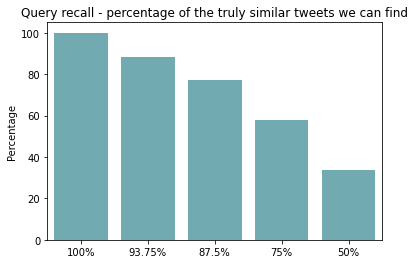

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [17]:
is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
predict_similar = query_result_similarity_lookup[is_predict_similar]
num_predict_similar = predict_similar.shape[0]
predict_similar

num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[8143, 8781, 9476, 10977, 14806]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 93.75% of terms, 82.05% tweets that we found similar are truly similar tweets
Using 87.5% of terms, 66.21% tweets that we found similar are truly similar tweets
Using 75% of terms, 42.77% tweets that we found similar are truly similar tweets
Using 50% of terms, 18.61% tweets that we found similar are truly similar tweets


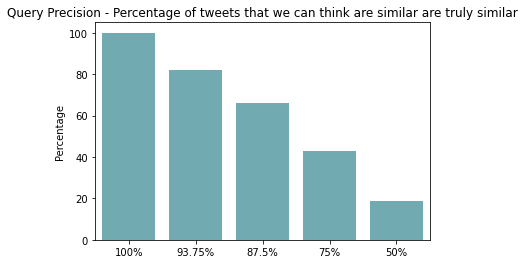

In [18]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [19]:
correct_search

,Result_100%,Result_93.75%,Result_87.5%,Result_75%,Result_50%,Similarity_100%,Similarity_93.75%,Similarity_87.5%,Similarity_75%,Similarity_50%,Lookups_100%,Lookups_93.75%,Lookups_87.5%,Lookups_75%,Lookups_50%
0,197710,197710,197710,197710,197710,0.57143,0.58333,0.58333,0.60000,0.50000,7350,3612,3612,2960,666
19,204516,204516,205909,205909,204516,0.66667,0.60000,0.50000,0.66667,1.00000,342,220,4,3,1
44,146902,146902,146902,146902,146902,0.50000,0.50000,0.50000,0.50000,0.50000,16284,16284,16284,16284,16284
48,205111,205111,205111,205111,205111,0.62500,0.62500,0.66667,0.80000,1.00000,176,176,90,75,45
78,35710,35710,35710,35710,35710,1.00000,1.00000,1.00000,1.00000,1.00000,32526,32526,19348,19348,12900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22837,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,7,5,4
22841,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,7,5,4
22842,98046,98046,98046,98046,98046,0.53846,0.53846,0.58333,0.50000,0.55556,96330,96330,87780,72950,47943
22844,206109,206109,206109,206109,206109,0.60000,0.60000,0.60000,0.75000,1.00000,5,5,5,4,2


In [20]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 1755, 2789, 3625, 2638]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 93.75% of terms, 24.36% queries need less lookups before correctly finding the true similar tweets
Using 87.5% of terms, 44.45% queries need less lookups before correctly finding the true similar tweets
Using 75% of terms, 77.21% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 95.72% queries need less lookups before correctly finding the true similar tweets


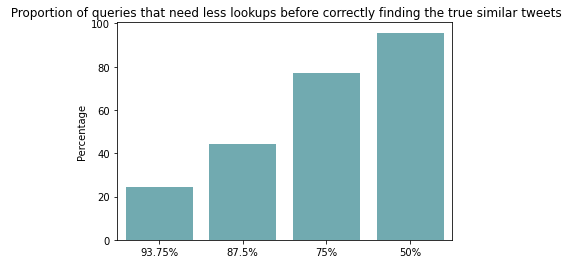

In [21]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

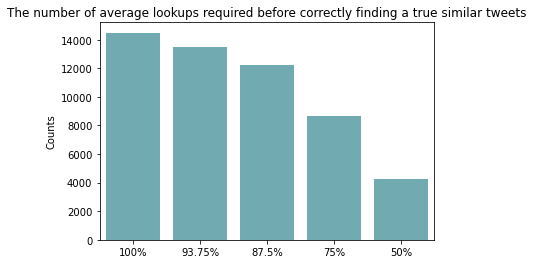

In [22]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [23]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 93.75% of terms, 6.92% of less lookups are needed for correctly finding a true similar tweets
By using 87.5% of terms, 15.6% of less lookups are needed for correctly finding a true similar tweets
By using 75% of terms, 39.98% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 70.62% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [24]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_93.75%,Index_time_run2_93.75%,Index_time_run3_93.75%,Index_time_run1_87.5%,Index_time_run2_87.5%,Index_time_run3_87.5%,Index_time_run1_75%,Index_time_run2_75%,Index_time_run3_75%,Index_time_run1_50%,Index_time_run2_50%,Index_time_run3_50%
0,11.5535,11.1856,13.7301,12.4063,12.6255,13.7984,12.1917,13.1643,12.5876,13.8967,13.1917,12.3369,14.0960,11.7523,13.1748
1,5.8457,5.1382,5.4383,5.8744,5.9152,5.5130,6.5243,5.4561,6.0390,5.7961,6.2948,5.7002,5.2339,5.0811,5.5625
2,4.6043,5.3439,4.6523,5.2833,5.4239,5.0060,5.2094,4.9320,4.7792,5.8678,6.3713,5.1839,5.0352,4.2378,5.1172
3,3.8486,4.3127,4.4391,4.6556,4.9452,4.7028,4.8148,4.4195,4.6576,5.0583,6.1043,4.3310,4.3782,3.7171,4.3733
4,3.7359,4.5352,4.2811,4.8025,4.8253,4.6245,5.5988,4.5515,4.4500,4.5647,6.0346,4.1516,3.9227,4.2157,3.7679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,1.8817,1.9949,2.1769,2.3983,2.9248,2.9016,2.5343,2.3259,2.1881,2.5598,2.9472,2.8321,2.0511,2.1576,2.0542
202,2.4258,1.9565,2.1936,2.3484,2.7435,2.8087,2.3738,2.2449,2.5869,3.4975,2.8493,2.6867,1.9901,2.0952,2.2449
203,2.2287,1.9077,2.0653,2.8240,2.7137,2.7151,2.2839,2.1814,3.1125,2.5580,2.7736,2.5330,2.0214,2.0528,2.2939
204,2.0891,1.9609,2.0793,2.3205,18.2835,2.7832,2.2722,2.2497,2.8092,2.5147,2.8352,2.5224,2.3337,2.0706,1.9200


By using 100% of terms, the average time for indexing 1000 tweets is 3.0585 milliseconds
By using 93.75% of terms, the average time for indexing 1000 tweets is 3.5822 milliseconds
By using 87.5% of terms, the average time for indexing 1000 tweets is 3.5475 milliseconds
By using 75% of terms, the average time for indexing 1000 tweets is 3.1961 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 2.9234 milliseconds


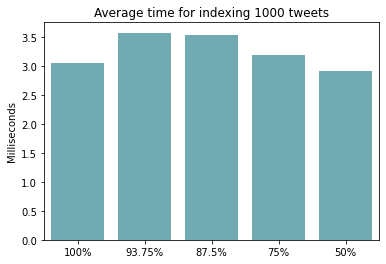

In [25]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [26]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_93.75%,Query_time_run2_93.75%,Query_time_run3_93.75%,Query_time_run1_87.5%,Query_time_run2_87.5%,Query_time_run3_87.5%,Query_time_run1_75%,Query_time_run2_75%,Query_time_run3_75%,Query_time_run1_50%,Query_time_run2_50%,Query_time_run3_50%
0,2.4708,2.5700,3.1055,1.9306,2.0907,2.4356,2.4928,2.3126,1.9951,2.1659,2.0412,2.1696,2.2893,2.1986,1.5398
1,351.7786,324.9563,336.5585,324.9906,333.0291,297.3654,293.5646,320.3423,315.3029,246.6419,307.5818,229.8544,169.1202,201.8268,190.4508
2,209.5788,221.7949,217.6451,198.0001,186.5148,177.2859,172.6576,174.7852,185.3874,134.2876,142.4022,123.7360,53.2982,61.9549,71.9454
3,212.7032,218.2909,224.0116,206.8039,193.9055,188.4430,184.4578,182.2605,192.7606,141.8017,142.2637,131.9093,59.2026,56.3813,53.4923
4,212.4503,232.1075,224.9298,217.6317,204.3588,194.1673,193.1099,202.7320,206.0428,156.4573,136.3455,140.1649,58.7363,67.2232,52.2412
5,213.1614,215.7063,213.5097,207.1407,206.7944,189.8635,180.7370,194.0218,202.9333,142.8251,133.4292,127.0436,56.4452,55.0642,53.0893
6,205.4062,217.1344,228.4037,219.2449,218.2941,197.0107,191.5721,208.5233,213.2675,166.0352,148.4500,149.8092,60.7083,57.1488,55.3056
7,202.6630,221.4953,217.1256,207.4754,216.4616,187.3182,176.8348,197.3164,194.2061,116.4050,158.6012,130.0994,61.9495,57.3950,56.3604
8,215.0175,233.1428,206.3056,200.0065,209.2041,182.4349,179.7904,203.6511,192.2581,118.6245,137.4188,135.6887,55.8808,48.7022,49.2671
9,214.9888,227.4351,216.8455,210.1204,208.3092,189.7946,188.3332,207.0061,198.7311,120.1060,135.4531,140.0826,57.4778,51.5946,50.5245


By using 100% of terms, the average time for querying 1000 tweets is 202.2462 milliseconds
By using 93.75% of terms, the average time for querying 1000 tweets is 184.1065 milliseconds
By using 87.5% of terms, the average time for querying 1000 tweets is 176.1074 milliseconds
By using 75% of terms, the average time for querying 1000 tweets is 119.9462 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 55.5371 milliseconds


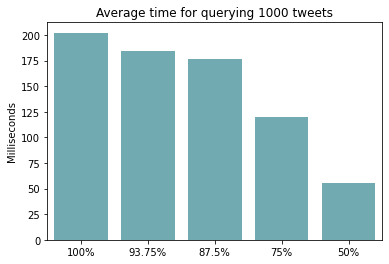

In [27]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))